# Cyclum on MB Dataset

In [12]:
%matplotlib inline

In [13]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt

import numpy as np

import cyclum.tuning

cell_line = "MB"

## Get Data

In [14]:
raw_Y = pd.read_pickle('../../data/McDavid/mb_df.pkl').T

cpt = pd.read_pickle('../../data/McDavid/mb_cpt.pkl').values
print("Original dimesion %d cells x %d genes." % raw_Y.shape)
print(f"G0/G1 {sum(cpt == 'g0/g1')}, S {sum(cpt == 's')}, G2/M {sum(cpt == 'g2/m')}")

#expression_level = np.sum(2**raw_Y, axis=0)

#ind = np.argpartition(expression_level.values, -150)[-150:]
#genes = raw_Y.columns[np.argpartition(expression_level.values, -6)[-6:]]
#Y = raw_Y.loc[:, raw_Y.columns[ind]]
#Y.values[:, :] = preprocessing.scale(Y)
Y = preprocessing.scale(raw_Y)

N, D = Y.shape
print('After filtering %d Cells (instances) x %d Genes (features)'%(N, D))

Original dimesion 342 cells x 253 genes.
G0/G1 [123], S [103], G2/M [116]
After filtering 342 Cells (instances) x 253 Genes (features)


## Auto Tuning

In [15]:
model = cyclum.tuning.CyclumAutoTune(Y, max_linear_dims=5, 
                                     epochs=1000, rate=5e-4, verbose=100,
                                     encoder_width=[30, 20])


Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...
epoch: 100/1000, loss:  0.6744, time elapsed:  4.84s, time left:  43.53s
epoch: 200/1000, loss:  0.6218, time elapsed:  8.91s, time left:  35.64s
epoch: 300/1000, loss:  0.6076, time elapsed:  12.90s, time left:  30.09s
epoch: 400/1000, loss:  0.6032, time elapsed:  16.94s, time left:  25.41s
epoch: 500/1000, loss:  0.6010, time elapsed:  20.91s, time left:  20.91s
epoch: 600/1000, loss:  0.5997, time elapsed:  24.82s, time left:  16.55s
epoch: 700/1000, loss:  0.5983, time elapsed:  28.87s, time left:  12.37s
epoch: 800/1000, loss:  0.5982, time elapsed:  32.95s, time left:  8.24s
epoch: 900/1000, loss:  0.5969, time elapsed:  36.94s, time left:  4.10s
epoch: 1000/1000, loss:  0.5952, time elapsed:  40.96s, time left:  0.00s
[0.5951873342893277]
[0.58435174523063, 0.46993334437048834, 0.43298941753135395, 0.40970032735018075, 0.3939374988874895, 0.3810903300337221]
    

It seems that $k=3$, i.e., 2 linear dimensions is the best.

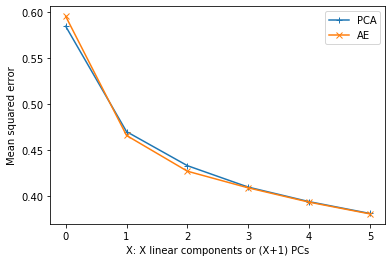

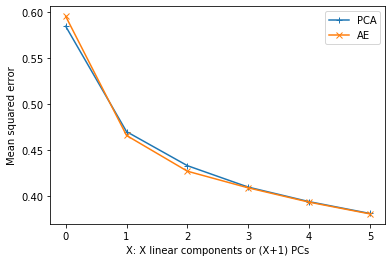

In [16]:
model.show_elbow()

## Training

In [17]:
model.train(Y, epochs=1000, verbose=100, rate=2e-4)

epoch: 100/1000, loss:  0.4730, time elapsed:  5.18s, time left:  46.65s
epoch: 200/1000, loss:  0.4455, time elapsed:  9.46s, time left:  37.83s
epoch: 300/1000, loss:  0.4353, time elapsed:  14.02s, time left:  32.71s
epoch: 400/1000, loss:  0.4323, time elapsed:  18.53s, time left:  27.80s
epoch: 500/1000, loss:  0.4300, time elapsed:  22.88s, time left:  22.88s
epoch: 600/1000, loss:  0.4292, time elapsed:  27.17s, time left:  18.11s
epoch: 700/1000, loss:  0.4294, time elapsed:  31.47s, time left:  13.49s
epoch: 800/1000, loss:  0.4286, time elapsed:  35.80s, time left:  8.95s
epoch: 900/1000, loss:  0.4284, time elapsed:  39.58s, time left:  4.40s
epoch: 1000/1000, loss:  0.4287, time elapsed:  43.22s, time left:  0.00s


In [18]:
pseudotime = model.predict_pseudotime(Y)

## Illustration and Evaluation

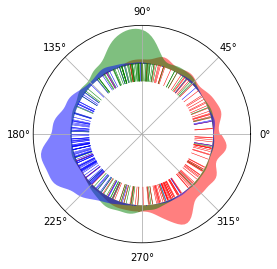

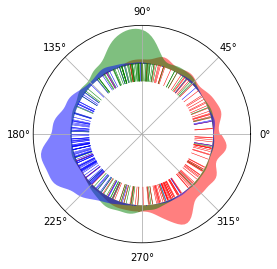

In [19]:
import cyclum.illustration
color_map = {"g0/g1": "red", "s": "green", "g2/m": "blue"}
cyclum.illustration.plot_round_distr_color(pseudotime[:, 0], cpt.squeeze(), color_map)

(0, 3.141592653589793)

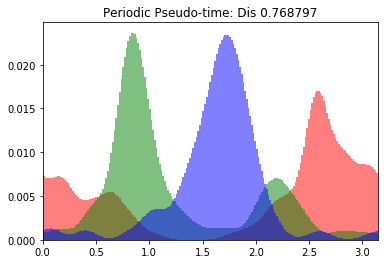

In [20]:
flat_embedding = (pseudotime % (2 * np.pi)) / 2
import cyclum.evaluation

width = 3.14 / 100 / 2;

discrete_time, distr_g0g1 = cyclum.evaluation.periodic_parzen_estimate(flat_embedding[np.squeeze(cpt)=='g0/g1', 0])
plt.bar(discrete_time, distr_g0g1, color='red', alpha=0.5, width = width)

discrete_time, distr_s = cyclum.evaluation.periodic_parzen_estimate(flat_embedding[np.squeeze(cpt)=='s', 0])
plt.bar(discrete_time, distr_s, color='green', alpha=0.5, width = width)

discrete_time, distr_g2m = cyclum.evaluation.periodic_parzen_estimate(flat_embedding[np.squeeze(cpt)=='g2/m', 0])
plt.bar(discrete_time, distr_g2m, color='blue', alpha=0.5, width = width)

correct_prob = cyclum.evaluation.precision_estimate([distr_g0g1, distr_s, distr_g2m], cpt, ['g0/g1', 's', 'g2/m'])
dis_score = correct_prob
plt.title("Periodic Pseudo-time: Dis %f" % dis_score)
plt.xlim([0, np.pi])

Note that this metric, although similar, is not exactly the same as the one we reported using mclust in R.

We use a non-parametric parzen window method to estimate the distribution here, 
while mclust uses a parametric normal mixture.

## Saving Results for Downstream Analysis in R

In [21]:
from cyclum.hdfrw import mat2hdf

mat2hdf(pseudotime, '../../data/McDavid/mb-pseudotime.h5')

In [22]:
layer = model.model.get_layer('decoder_out')
weights = layer.get_weights()[0]
mat2hdf(weights, "../../data/McDavid/mb-weight.h5")

